In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Загрузим данные и посмотрим на небольшую часть
data = pd.read_csv('./breast-cancer_1.csv')

In [3]:
num_cols = [
    'deg-malig',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'breast',
    'age',
    'irradiat'
]

cat_cols = [
    'menopause',
    'breast-quad'
]

target_col = 'class'

cols = num_cols + cat_cols + [target_col]

In [4]:
data = data[cols]
# Возраст записан не в виде числа, исправим это, вырезав последний символ и скастовав к числу
data['age'] = data['age'].str.slice(0, -3).astype(int)

data['tumor-size'] = data['tumor-size'].str.slice(0, -2)
data['tumor-size'] = data['tumor-size'].str.replace('-', '').astype(int) + 2

data['inv-nodes'] = data['inv-nodes'].str.slice(0, -2)
data['inv-nodes'] = data['inv-nodes'].str.replace('-', '').astype(int) + 1

data['node-caps'] = (data['node-caps'] == 'yes').astype(int)
data['irradiat'] = (data['irradiat'] == 'yes').astype(int)
data['breast'] = (data['breast'] == 'right').astype(int)
data['class'] = (data['class'] == 'recurrence-events').astype(int)

data = data.loc[data['breast-quad'] != '?']

In [5]:
# Задание: Теперь добавьте в датафрейм колонки для всех категориальных фичей и обновите список категориальных фичей
data = pd.get_dummies(data, columns=cat_cols)
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
cat_cols = cat_cols_new

In [6]:
from imblearn.over_sampling import ADASYN

In [7]:
X = data[num_cols + cat_cols].to_numpy()
print(X.shape)
y = data['class'].to_numpy()
print(y.shape)
ros = ADASYN(random_state=0)
X_res, y_res = ros.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)

(285, 15)
(285,)
(412, 15)
(412,)


In [8]:
import random
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, 
    y_res, 
    test_size=0.2, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [10]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
pca.fit(X_train)
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
gbc = GradientBoostingClassifier(loss='exponential', n_estimators=200, learning_rate=1.4, criterion='friedman_mse', max_depth = 4)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.7469879518072289

In [27]:
from sklearn import metrics

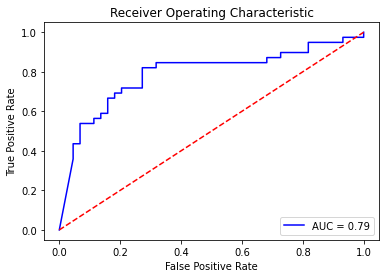

In [28]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gbc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# precision-recall curve
presicion, recall, threshold = metrics.precision_recall_curve(y_test, preds)
ap = metrics.auc(y_test, preds)
plt.title('Percision-recall curve')
plt.plot(recall, presicion, 'b', label = 'AP = %0.2f' % ap)
plt.legend(loc = 'lower right')
plt.ylabel('Presicion')
plt.xlabel('Recall')
plt.show()

ValueError: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV
# заново создадим модель, указав солвер
gbc = GradientBoostingClassifier()

# опишем сетку, по которой будем искать
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300], # также можно указать обычный массив, [1, 2, 3, 4]
    'learning_rate': [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    'criterion': ['friedman_mse', 'squared_error'],
    'loss': ['deviance', 'exponential'],
    'max_depth': [1, 2, 3, 4, 5]
}

# создадим объект GridSearchCV
search = GridSearchCV(gbc, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

# запустим поиск
search.fit(X_train, y_train)

# выведем наилучшие параметры
print(search.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 1.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 50}
